In [1]:
import os
import torch
import numpy as np
from ezflow.data import DeviceDataLoader, DataloaderCreator

from nnflow import flow_to_image
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from ezflow.models import build_model
from ezflow.utils import AverageMeter, InputPadder
from nnflow import GMFlowV2, SCCFlow
from nnflow.models.gmflow import NAT

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
norm_params = {"use":True, "mean":[0.485, 0.456, 0.406], "std":[0.229, 0.224, 0.225]}

In [5]:
loader = DataloaderCreator(batch_size=2, num_workers=1, pin_memory=True)
loader.add_MPISintel(
    root_dir="../../../../Datasets/MPI_Sintel/",
    crop=True,
    crop_type="center",
    crop_size=[384, 1024],
    dstype="final",
    split="training", 
    augment=False,
    norm_params=norm_params
)
sintel_ds = loader.dataset_list[0]

In [6]:
(img1, img2), flow = sintel_ds[354]

In [7]:
model = build_model(
        "GMFlowV2", 
        cfg_path="../configs/gmflow/models/gmflow_v13.yaml", 
        custom_cfg=True
    )

# model = build_model(
#         "RAFT", 
#         cfg_path="../configs/raft/models/raft.yaml", 
#         custom_cfg=True
#     )
# model.cfg.UPDATE_ITERS =32

In [64]:
state_dict = torch.load("../../results/gmflow/ckpts/exp225/gmflowv2_best.pth", map_location=torch.device('cpu'))
# state_dict = torch.load("../../results/raft/ckpts/exp207/raft_step100000.pth", map_location=torch.device('cpu'))

In [67]:
model.load_state_dict(state_dict)#['model_state_dict'])
model = model.to(device)

In [68]:
img1 = img1.to(device)
img2 = img2.to(device)

In [69]:
# padder = InputPadder(img1.shape, divisor=1)
# img1, img2 = padder.pad(img1, img2)

In [70]:
model.eval()

output = model(img1.unsqueeze(dim=0), img2.unsqueeze(dim=0))
flow_pred = output["flow_upsampled"] #padder.unpad(output["flow_upsampled"]) * 20.0
flow_pred.shape

torch.Size([1, 2, 384, 1024])

In [71]:
flow_pred = flow_pred.squeeze(dim=0).cpu().detach().permute(1,2,0).numpy()
flow_pred.shape

(384, 1024, 2)

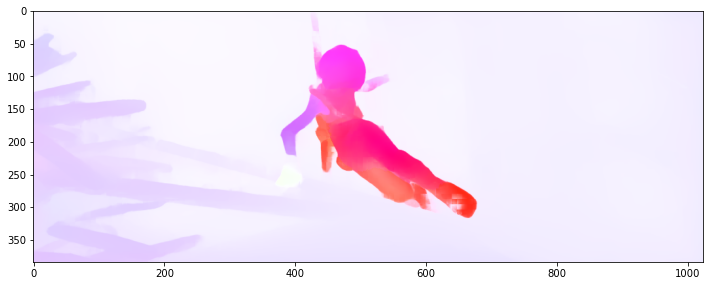

In [72]:
flow_pred_color = flow_to_image(flow_pred)
plt.figure(figsize=(12,10))

plt.imshow(flow_pred_color)

In [73]:
# plt.figure(figsize=(12,10))

# plt.imshow(img1.permute(1,2,0).numpy().astype(np.uint8))

In [74]:
# plt.figure(figsize=(12,10))

# plt.imshow(img2.permute(1,2,0).numpy().astype(np.uint8))

In [75]:
# flow_color = flow_to_image(flow.permute(1,2,0).numpy())

In [76]:
# plt.figure(figsize=(12,10))

# plt.imshow(flow_color)

In [77]:
# _img1 = Image.fromarray(img1.permute(1,2,0).numpy().astype(np.uint8))
# _img2 = Image.fromarray(img2.permute(1,2,0).numpy().astype(np.uint8))
_flow = Image.fromarray(flow_pred_color)

# _img1.size, _img2.size, _flow.size
_flow.size

(1024, 384)

In [78]:
filepath = "../../viz/nat_gm"

os.makedirs(filepath, exist_ok=True)

# _img1.save(filepath+"/img1.jpg")
# _img2.save(filepath+"/img2.jpg")
_flow.save(filepath+"/flow_kubric_plusv3.jpg")